In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, precision_recall_curve, f1_score
import numpy as np
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder,StandardScaler, OneHotEncoder,TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')


C:\Users\amogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset pre-processing, Feature Engineering
To train ML model, I need to clean dataset by getting rid of outliers, missing values. Then split dataset into train and test sets. Use conditions to ensure that proportions of output remain same in both splits.

**Precautions for Modelling Procedure(Based on EDA)**

- **Imbalanced Dataset:**  
    The number of attrited customers is much lower than existing customers (roughly 4:1). This imbalance can bias the model. Techniques like **SMOTE** or class weighting should be applied during training.

- **Card Category Distribution:**  
    Most customers have a Blue Card; higher card categories have very few members. This can affect the model’s ability to generalize for premium segments.

- **Unknown Categories:**  
    The "Unknown" category appears in **Income Category**, **Education Level**, and **Marital Status**. Consider how to handle these missing or ambiguous values (e.g., imputation, separate category). But in all 3 **Unknown Category** can't be dropped as it is 2nd or 3rd highest in churn probabaility in each case

- **Data Anomaly:**  
    A majority of people joined exactly 36 months ago, which is an anomaly in the data. Investigate or consider this during feature engineering.

- **Highly Correlated Features:**  
    **Avg. open to buy** is very similar to **Credit Limit** (perfect linear correlation). Keep only one of these features to avoid multicollinearity.

**Feature Engineering**
***Division Features (A/B):***
These features are ratios, created by dividing one column by another (sometimes adding 1 to the denominator to avoid division by zero). They help capture per-unit relationships, such as:
- Transaction amount per transaction count, revolving balance, open to buy, contacts, inactive months, relationship count, dependent
- Revolving balance per transaction count, contacts, inactive months, relationship count, dependent
- Open to buy per transaction count, contacts, inactive months, relationship count, dependent
- Credit limit per transaction count, contacts, inactive months, relationship count, dependent
- Amount change per transaction count, contacts, inactive months, relationship count, dependent
- Utilization ratio per transaction count, transaction amount, revolving balance, open to buy, credit limit, contacts, inactive months, relationship count, dependent
- Transaction count per revolving balance, open to buy, credit limit, dependent, inactive months, relationship count

***Addition Features (A+B):***
These features are sums, created by adding two columns together. They capture total or combined values, such as:
- Total transaction amount plus revolving balance
- Total transaction amount plus open to buy
- Total transaction amount plus credit limit
- Total revolving balance plus open to buy
- Total revolving balance plus credit limit

These engineered features help the model learn more complex relationships between customer behaviors and churn.




In [2]:
df = pd.read_csv('../data/BankChurners.csv')

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
df.drop(columns=['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],inplace=True)

In [5]:
df.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [7]:
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [8]:
df.shape

(10127, 20)

In [9]:
for col in df:
  print(col,df[col].unique())

Attrition_Flag ['Existing Customer' 'Attrited Customer']
Customer_Age [45 49 51 40 44 32 37 48 42 65 56 35 57 41 61 47 62 54 59 63 53 58 55 66
 50 38 46 52 39 43 64 68 67 60 73 70 36 34 33 26 31 29 30 28 27]
Gender ['M' 'F']
Dependent_count [3 5 4 2 0 1]
Education_Level ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status ['Married' 'Single' 'Unknown' 'Divorced']
Income_Category ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card_Category ['Blue' 'Gold' 'Silver' 'Platinum']
Months_on_book [39 44 36 34 21 46 27 31 54 30 48 37 56 42 49 33 28 38 41 43 45 52 40 50
 35 47 32 20 29 25 53 24 55 23 22 26 13 51 19 15 17 18 16 14]
Total_Relationship_Count [5 6 4 3 2 1]
Months_Inactive_12_mon [1 4 2 3 6 0 5]
Contacts_Count_12_mon [3 2 0 1 4 5 6]
Credit_Limit [12691.  8256.  3418. ...  5409.  5281. 10388.]
Total_Revolving_Bal [ 777  864    0 ...  534  476 2241]
Avg_Open_To_Buy [11914.  7392.  3418. ... 11831.  5

In [10]:
df.replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)

In [11]:
df.replace({'M':1,'F':0},inplace=True)

In [12]:
df.dtypes

Attrition_Flag                int64
Customer_Age                  int64
Gender                        int64
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [13]:
categorical_ordinal_features = [
    'Education_Level',
    'Income_Category',
    'Card_Category'
]# That are 
categorical_nominal_features = ['Martial_Status']

In [14]:
# Total_Trans_Amt per other features
df['Trans_Amt_per_Trans_Ct'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
df['Trans_Amt_per_Rev_Bal'] = df['Total_Trans_Amt'] / (df['Total_Revolving_Bal'] + 1)
df['Trans_Amt_per_Open_To_Buy'] = df['Total_Trans_Amt'] / (df['Avg_Open_To_Buy'] + 1)
df['Trans_Amt_per_Contacts'] = df['Total_Trans_Amt'] / (df['Contacts_Count_12_mon'] + 1)
df['Trans_Amt_per_Inactive'] = df['Total_Trans_Amt'] / (df['Months_Inactive_12_mon'] + 1)
df['Trans_Amt_per_Relationship'] = df['Total_Trans_Amt'] / (df['Total_Relationship_Count'] + 1)
df['Trans_Amt_per_Dependent'] = df['Total_Trans_Amt'] / (df['Dependent_count'] + 1)
df['Trans_Amt_per_Months_Inactive'] = df['Total_Trans_Amt'] / (df['Months_Inactive_12_mon'] + 1)

# Total_Revolving_Bal per other features
df['Rev_Bal_per_Trans_Ct'] = df['Total_Revolving_Bal'] / df['Total_Trans_Ct']
df['Rev_Bal_per_Contacts'] = df['Total_Revolving_Bal'] / (df['Contacts_Count_12_mon'] + 1)
df['Rev_Bal_per_Inactive'] = df['Total_Revolving_Bal'] / (df['Months_Inactive_12_mon'] + 1)
df['Rev_Bal_per_Relationship'] = df['Total_Revolving_Bal'] / (df['Total_Relationship_Count'] + 1)
df['Rev_Bal_per_Dependent'] = df['Total_Revolving_Bal'] / (df['Dependent_count'] + 1)
df['Rev_Bal_per_Months_Inactive'] = df['Total_Revolving_Bal'] / (df['Months_Inactive_12_mon'] + 1)

# Avg_Open_To_Buy per other features
df['Open_To_Buy_per_Trans_Ct'] = df['Avg_Open_To_Buy'] / df['Total_Trans_Ct']
df['Open_To_Buy_per_Contacts'] = df['Avg_Open_To_Buy'] / (df['Contacts_Count_12_mon'] + 1)
df['Open_To_Buy_per_Inactive'] = df['Avg_Open_To_Buy'] / (df['Months_Inactive_12_mon'] + 1)
df['Open_To_Buy_per_Relationship'] = df['Avg_Open_To_Buy'] / (df['Total_Relationship_Count'] + 1)
df['Open_To_Buy_per_Dependent'] = df['Avg_Open_To_Buy'] / (df['Dependent_count'] + 1)
df['Open_To_Buy_per_Months_Inactive'] = df['Avg_Open_To_Buy'] / (df['Months_Inactive_12_mon'] + 1)

# Credit_Limit per other features
df['Credit_Limit_per_Trans_Ct'] = df['Credit_Limit'] / df['Total_Trans_Ct']
df['Credit_Limit_per_Contacts'] = df['Credit_Limit'] / (df['Contacts_Count_12_mon'] + 1)
df['Credit_Limit_per_Inactive'] = df['Credit_Limit'] / (df['Months_Inactive_12_mon'] + 1)
df['Credit_Limit_per_Relationship'] = df['Credit_Limit'] / (df['Total_Relationship_Count'] + 1)
df['Credit_Limit_per_Dependent'] = df['Credit_Limit'] / (df['Dependent_count'] + 1)
df['Credit_Limit_per_Months_Inactive'] = df['Credit_Limit'] / (df['Months_Inactive_12_mon'] + 1)

# Total_Amt_Chng_Q4_Q1 per other features
df['Amt_Chng_per_Trans_Ct'] = df['Total_Amt_Chng_Q4_Q1'] / df['Total_Trans_Ct']
df['Amt_Chng_per_Contacts'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Contacts_Count_12_mon'] + 1)
df['Amt_Chng_per_Inactive'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Months_Inactive_12_mon'] + 1)
df['Amt_Chng_per_Relationship'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Total_Relationship_Count'] + 1)
df['Amt_Chng_per_Dependent'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Dependent_count'] + 1)
df['Amt_Chng_per_Months_Inactive'] = df['Total_Amt_Chng_Q4_Q1'] / (df['Months_Inactive_12_mon'] + 1)

# Avg_Utilization_Ratio per other features
df['Utilization_per_Trans_Ct'] = df['Avg_Utilization_Ratio'] / df['Total_Trans_Ct']
df['Utilization_per_Trans_Amt'] = df['Avg_Utilization_Ratio'] / df['Total_Trans_Amt']
df['Utilization_per_Rev_Bal'] = df['Avg_Utilization_Ratio'] / (df['Total_Revolving_Bal'] + 1)
df['Utilization_per_Open_To_Buy'] = df['Avg_Utilization_Ratio'] / (df['Avg_Open_To_Buy'] + 1)
df['Utilization_per_Credit_Limit'] = df['Avg_Utilization_Ratio'] / (df['Credit_Limit'] + 1)
df['Utilization_per_Contacts'] = df['Avg_Utilization_Ratio'] / (df['Contacts_Count_12_mon'] + 1)
df['Utilization_per_Inactive'] = df['Avg_Utilization_Ratio'] / (df['Months_Inactive_12_mon'] + 1)
df['Utilization_per_Relationship'] = df['Avg_Utilization_Ratio'] / (df['Total_Relationship_Count'] + 1)
df['Utilization_per_Dependent'] = df['Avg_Utilization_Ratio'] / (df['Dependent_count'] + 1)

# Total_Trans_Ct per other features
df['Trans_Ct_per_Rev_Bal'] = df['Total_Trans_Ct'] / (df['Total_Revolving_Bal'] + 1)
df['Trans_Ct_per_Open_To_Buy'] = df['Total_Trans_Ct'] / (df['Avg_Open_To_Buy'] + 1)
df['Trans_Ct_per_Credit_Limit'] = df['Total_Trans_Ct'] / (df['Credit_Limit'] + 1)
df['Trans_Ct_per_Dependent'] = df['Total_Trans_Ct'] / (df['Dependent_count'] + 1)
df['Trans_Ct_per_Months_Inactive'] = df['Total_Trans_Ct'] / (df['Months_Inactive_12_mon'] + 1)
df['Trans_Ct_per_Relationship'] = df['Total_Trans_Ct'] / (df['Total_Relationship_Count'] + 1)


df['Sum_Trans_Amt_Rev_Bal'] = df['Total_Trans_Amt'] + df['Total_Revolving_Bal']
df['Sum_Trans_Amt_Open_To_Buy'] = df['Total_Trans_Amt'] + df['Avg_Open_To_Buy']
df['Sum_Trans_Amt_Credit_Limit'] = df['Total_Trans_Amt'] + df['Credit_Limit']
df['Sum_Rev_Bal_Open_To_Buy'] = df['Total_Revolving_Bal'] + df['Avg_Open_To_Buy']
df['Sum_Rev_Bal_Credit_Limit'] = df['Total_Revolving_Bal'] + df['Credit_Limit']


In [15]:
X = df.drop(columns='Attrition_Flag')
y = df['Attrition_Flag']

In [16]:
# For linear
one_hot_encode = X.dtypes[X.dtypes == object].index.to_list()
cols_to_scale = X.dtypes[X.dtypes != object].index.to_list()
cols_to_drop = [
    'Avg_Open_To_Buy',
    'Open_To_Buy_per_Trans_Ct',
    'Open_To_Buy_per_Contacts',
    'Open_To_Buy_per_Inactive',
    'Open_To_Buy_per_Relationship',
    'Open_To_Buy_per_Dependent',
    'Open_To_Buy_per_Months_Inactive'
]

linear_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), one_hot_encode),
    ('scaler', StandardScaler(), cols_to_scale),
    ('drop', 'drop', cols_to_drop)
])

In [17]:
# For Tree
target_encoding_features = ['Marital_Status']

ordinal_encode = {
    'Education_Level': ['Uneducated',
                        'High School',
                        'College',
                        'Graduate',
                        'Post-Graduate',
                        'Doctorate',
                        'Unknown'],
    'Income_Category': ['Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +',
                        'Unknown'],
    'Card_Category': ['Blue',
                      'Silver',
                      'Gold',
                      'Platinum']
}
ordinal_features = list(ordinal_encode.keys())
ordinal_order = [ordinal_encode[col] for col in ordinal_features]
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
tree_preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_order), ordinal_features),
    ('target', TargetEncoder(cv=5), target_encoding_features),
    ('passthrough', 'passthrough', numeric_features)
])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [19]:
linear_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), one_hot_encode),
    ('scaler', StandardScaler(), cols_to_scale),
    ('drop', 'drop', cols_to_drop)
])

In [20]:
# 1. Ordinal Encoding
ordinal_features = list(ordinal_encode.keys())
ordinal_order = [ordinal_encode[col] for col in ordinal_features]

# 2. All numeric (no scaling needed)
numeric_features =  X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. ColumnTransformer for tree models
tree_preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_order), ordinal_features),
    ('target', TargetEncoder(cv=5), target_encoding_features),
    ('passthrough', 'passthrough', numeric_features)
])


## Model Trainning, Tuning
* Trainning multiple models to test and verify the best one, for this case. Further trainning as using LightGBM is best to as it gives best f1 score and roc-auc score.
* Using class weights for optimization due to consideration of data imbalance known from EDA, as balanced weights.
* Using RFE(Recursive Feature Elimination) to eliminate excess features that are that less affect prediction of model.
* Then using Bayesian optmization to optimize hyperparamters for model.This is optional in this case as model has 0.99 rocc-auc score without bayesian optimization. So, I won't be using it.
* Used Cost matrix to perform feature selection by Recursive Feature Elimination. As cost is the need to optimized for business. 
* I used guesstimate to estimate cost of missing churners, Incorrectly identification of loyal users.
**Guesstimate**
* Cost for false negatives is equal to Customer Lifetime Value(CLV). Cost for false positives is retention campaign cost. I will do it across card categories due significant differences in usage pattern accross card types.
* Calculating Cost for 
    - Cost_fn = CLV
              = (Avg_monthly_spend)x(Revenue_Margin)x(Avg_Customer_Span_Months)

* Revenue Margin is usually 5% for bank.
* Monthly spend is (Total_Trans_Amt/Months_on_Book). Thus its average value is the way to go.
* Average on months on book for an attrited customer is Average Customer Span.
    <div><style scoped>.dataframe tbody tr th:only-of-type {vertical-align: middle;} .dataframe tbody tr th {vertical-align: top;} .dataframe thead th {text-align: right;} </style> <table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>Card Category</th> <th>Customer Lifetime Value</th> </tr></thead> <tbody> <tr> <th>Blue</th> <td>₹212.677110</td> </tr> <tr> <th>Gold</th> <td>₹366.745284</td> </tr> <tr> <th>Platinum</th> <td>₹446.884138</td> </tr> <tr> <th>Silver</th> <td>₹338.015952</td> </tr> </tbody> </table> </div> 
* Cost_fp is markting spend which increses with card level. As people with higher card level need more premium expenses for offers.
    <div><style scoped>.dataframetbodytrth:only-of-type{vertical-align:middle;}.dataframetbodytrth{vertical-align:top;}.dataframetheadth{text-align:right;}</style><table border="1"class="dataframe"><thead><tr style="text-align:right;"><th>Card Category</th><th>fp_cost</th><th>fn_cost</th></tr></thead><tbody><tr><th>Blue</th><td>₹50</td><td>₹212.677110</td></tr><tr><th>Silver</th><td>₹100</td><td>₹338.015952</td></tr><tr><th>Gold</th><td>₹200</td><td>₹366.745284</td></tr><tr><th>Platinum</th><td>₹300</td><td>₹446.884138</td></tr></tbody></table></div>

In [21]:
monthly_spend = df.groupby('Card_Category').Total_Trans_Amt.mean()/df.groupby('Card_Category').Months_on_book.mean()
span = df[df['Attrition_Flag']==1].groupby('Card_Category').Months_on_book.mean()
CLV_by_Card_Type=monthly_spend*span*0.05
CLV = pd.DataFrame({'Card Category': CLV_by_Card_Type.index, 'Customer Lifetime Value': CLV_by_Card_Type.values}).set_index('Card Category')

In [22]:
fp_cost_mapping = {
    'Blue': 50,
    'Silver': 100,
    'Gold': 200,
    'Platinum': 300
}
FP_cost = pd.DataFrame(list(fp_cost_mapping.items()), columns=['Card_Category', 'FP_Cost']).set_index('Card_Category')
costs_by_card = pd.concat([FP_cost, CLV], axis=1).rename(columns={'Customer Lifetime Value': 'fn_cost', 'FP_Cost': 'fp_cost'})

### Choose Model

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [24]:
linear_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear SVC': LinearSVC(max_iter=10000),
    'KNN': KNeighborsClassifier()
}

tree_models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier()
}

In [25]:
# For Tree
target_encoding_features = ['Marital_Status']

ordinal_encode = {
    'Education_Level': ['Uneducated',
                        'High School',
                        'College',
                        'Graduate',
                        'Post-Graduate',
                        'Doctorate',
                        'Unknown'],
    'Income_Category': ['Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +',
                        'Unknown'],
    'Card_Category': ['Blue',
                      'Silver',
                      'Gold',
                      'Platinum']
}
ordinal_features = list(ordinal_encode.keys())
ordinal_order = [ordinal_encode[col] for col in ordinal_features]
tree_preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_order), ordinal_features),
    ('target', TargetEncoder(cv=5), target_encoding_features),
    ('passthrough', 'passthrough', numeric_features)
])

In [26]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'

    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc if auc=='N/A' else round(auc, 4)}")

    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title("ROC Curve")
        plt.grid()
        plt.show()

    return {
        'F1 Score': f1,
        'ROC AUC': auc if auc != 'N/A' else None
    }


In [27]:
def run_all_models_with_preprocessors(X_train, X_test, y_train, y_test, models, preprocessor):

    results = {}

    for name, model in models.items():
        print(f"\n🔧 Training: {name}")

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)

        print("Evaluating...")
        metrics = evaluate_model(pipeline, X_test, y_test)

        results[name] = metrics

    return pd.DataFrame(results).T.sort_values("F1 Score", ascending=False)



Linear Models Evaluation

🔧 Training: Logistic Regression
Evaluating...
Confusion Matrix:
[[1660   41]
 [ 129  196]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1701
           1       0.83      0.60      0.70       325

    accuracy                           0.92      2026
   macro avg       0.88      0.79      0.82      2026
weighted avg       0.91      0.92      0.91      2026

F1 Score: 0.6975
ROC AUC: 0.9444


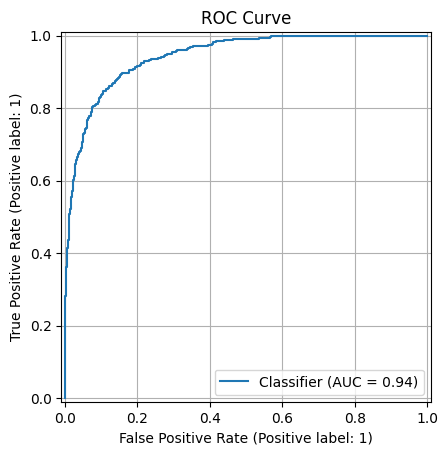


🔧 Training: Linear SVC
Evaluating...
Confusion Matrix:
[[1661   40]
 [ 132  193]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1701
           1       0.83      0.59      0.69       325

    accuracy                           0.92      2026
   macro avg       0.88      0.79      0.82      2026
weighted avg       0.91      0.92      0.91      2026

F1 Score: 0.6918
ROC AUC: N/A

🔧 Training: KNN
Evaluating...
Confusion Matrix:
[[1663   38]
 [ 129  196]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1701
           1       0.84      0.60      0.70       325

    accuracy                           0.92      2026
   macro avg       0.88      0.79      0.83      2026
weighted avg       0.91      0.92      0.91      2026

F1 Score: 0.7013
ROC AUC: 0.9164


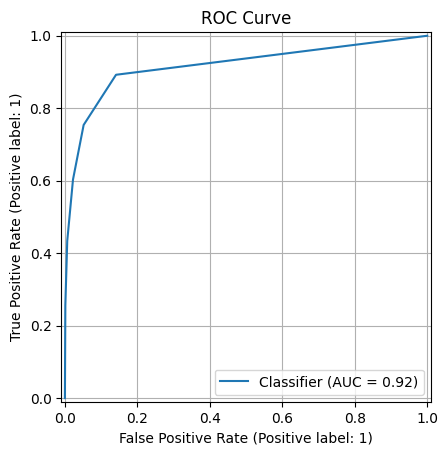


Tree-Based Models Evaluation

🔧 Training: Decision Tree
Evaluating...
Confusion Matrix:
[[1631   70]
 [  71  254]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1701
           1       0.78      0.78      0.78       325

    accuracy                           0.93      2026
   macro avg       0.87      0.87      0.87      2026
weighted avg       0.93      0.93      0.93      2026

F1 Score: 0.7827
ROC AUC: 0.8702


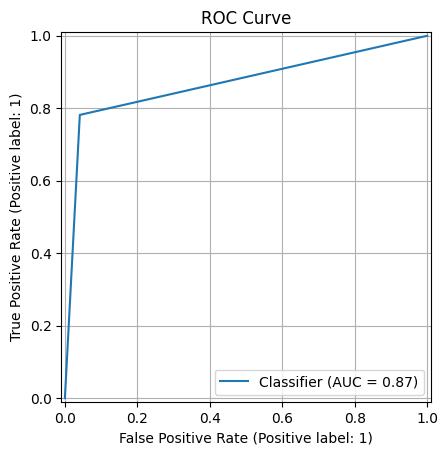


🔧 Training: Random Forest
Evaluating...
Confusion Matrix:
[[1678   23]
 [  81  244]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1701
           1       0.91      0.75      0.82       325

    accuracy                           0.95      2026
   macro avg       0.93      0.87      0.90      2026
weighted avg       0.95      0.95      0.95      2026

F1 Score: 0.8243
ROC AUC: 0.9844


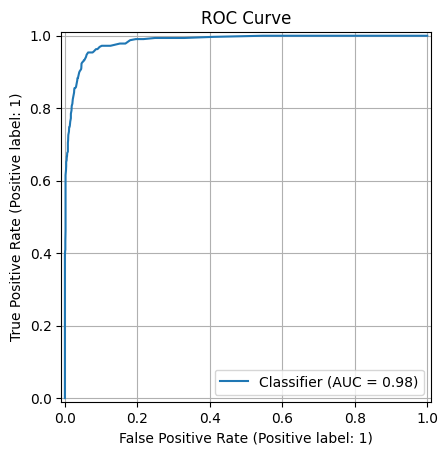


🔧 Training: LightGBM
[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15323
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start training from score -1.652874
Evaluating...
Confusion Matrix:
[[1680   21]
 [  48  277]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.93      0.85      0.89       325

    accuracy                           0.97      2026
   macro avg       0.95      0.92      0.93      2026
weighted avg       0.97      0.97      0.97      2026

F1 Score: 0.8892
ROC AUC: 0.9928


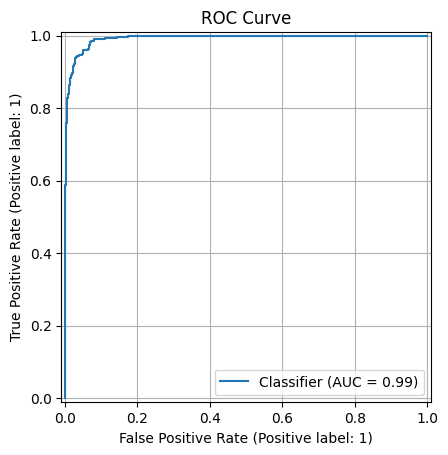

In [28]:
print("Linear Models Evaluation")
linear_results = run_all_models_with_preprocessors(
    X_train, X_test, y_train, y_test,
    models=linear_models,
    preprocessor=linear_preprocessor
)

print("\nTree-Based Models Evaluation")
tree_results = run_all_models_with_preprocessors(
    X_train, X_test, y_train, y_test,
    models=tree_models,
    preprocessor=tree_preprocessor
)


### Recursive Feature Elimination

In [29]:
def find_optimal_threshold(y_true, y_probs, cost_by_card, card_category):
    thresholds = np.arange(0.01, 0.99, 0.01)
    costs = []

    for t in thresholds:
        y_pred = (y_probs > t).astype(int)

        # Create DataFrame in one go
        people_data = pd.DataFrame({
            'true': y_true,
            'pred': y_pred,
            'card': card_category
        })

        # Add FN and FP flags
        people_data['is_fn'] = (people_data['true'] == 1) & (people_data['pred'] == 0)
        people_data['is_fp'] = (people_data['true'] == 0) & (people_data['pred'] == 1)

        # Group by card category and sum
        counts = people_data.groupby('card')[['is_fn', 'is_fp']].sum()

        # Merge with cost matrix
        cost_calc = counts.join(cost_by_card)

        # Compute cost per card category
        cost_calc['category_total_cost'] = (
            cost_calc['is_fn'] * cost_calc['fn_cost'] +
            cost_calc['is_fp'] * cost_calc['fp_cost']
        )

        # Total cost at this threshold
        total_cost = cost_calc['category_total_cost'].sum()
        costs.append((t, total_cost))

    # Final results
    cost_df = pd.DataFrame(costs, columns=['Threshold', 'Total_Cost'])
    best_row = cost_df.loc[cost_df['Total_Cost'].idxmin()]
    
    return best_row, cost_df


In [30]:
# Pre-transform entire training and test sets once outside loop
X_train_tree_full = tree_preprocessor.fit_transform(X_train, y_train)
X_test_tree_full = tree_preprocessor.transform(X_test)
# Store column names before transformation (RFE needs them)
all_feature_names = X_train.columns.tolist()
# Initialize result container
cost_optim_df = []
# Use a shared model base
base_model = LGBMClassifier(class_weight='balanced', verbose=-1)

# Begin RFE + threshold cost search
for num_features in range(1, len(all_feature_names) + 1):
    
    if num_features % 5 == 0:
        print(f'{num_features}/{len(all_feature_names)} features evaluated...')

    # RFE to select n features
    rfe = RFE(estimator=base_model, n_features_to_select=num_features)
    rfe.fit(X_train_tree_full, y_train)

    # Selected columns from original space (before preprocessing)
    selected_mask = rfe.support_

    # Slice reduced datasets
    X_train_selected = X_train_tree_full[:, selected_mask]
    X_test_selected = X_test_tree_full[:, selected_mask]

    # Train model on selected features
    base_model.fit(X_train_selected, y_train)
    y_probs = base_model.predict_proba(X_test_selected)[:, 1]

    # Cost-sensitive threshold search
    best_row, cost_report_df = find_optimal_threshold(
        y_test,
        y_probs,
        cost_by_card=costs_by_card,
        card_category=X_test['Card_Category']
    )

    # Store result
    cost_optim_df.append({
        'Threshold': best_row['Threshold'],
        'Min_Cost': best_row['Total_Cost'],
        'N_features': num_features
    })

# Convert to final DataFrame
cost_optim_df = pd.DataFrame(cost_optim_df)


5/71 features evaluated...
10/71 features evaluated...
15/71 features evaluated...
20/71 features evaluated...
25/71 features evaluated...
30/71 features evaluated...
35/71 features evaluated...
40/71 features evaluated...
45/71 features evaluated...
50/71 features evaluated...
55/71 features evaluated...
60/71 features evaluated...
65/71 features evaluated...
70/71 features evaluated...


In [31]:
cost_optim_df.loc[cost_optim_df['Min_Cost'].idxmin(),:]

Threshold        0.210000
Min_Cost      6189.448207
N_features      44.000000
Name: 43, dtype: float64

In [32]:
X_train_tree = tree_preprocessor.fit_transform(X_train, y_train)
X_test_tree = tree_preprocessor.transform(X_test)
model_weighted = LGBMClassifier(
    class_weight='balanced',
    verbose=-1
)
rfe = RFE(estimator=model_weighted, n_features_to_select=34)
rfe.fit(X_train_tree, y_train)
# Get selected feature indices from RFE
selected_features = X.columns[rfe.support_].tolist()
selected_indices = [X_train.columns.get_loc(f) for f in selected_features]

X_train_selected = X_train_tree[:, selected_indices]
X_test_selected = X_test_tree[:, selected_indices]

model_weighted.fit(X_train_selected, y_train)

LGBMClassifier(class_weight='balanced', verbose=-1)

## Model Report
* Used Cost matrix to perform feature selection by Recursive Feature Elimination. As cost is the need to optimized for business. 
* I used guesstimate to estimate cost of missing churners, Incorrectly identification of loyal users.
* A lot of features engineered are a part of top features afftecting model outcome indicating importance of Feature Enigineering.
* As predicted by EDA Total_Trans_Amt and Total_Trans_Ct are top affecting features.
* A ₹7442 is final cost for model down ₹30000 initial cost after cost optimization

Best Threshold: 0.2
Threshold        0.200000
Total_Cost    6602.125317
Name: 19, dtype: float64


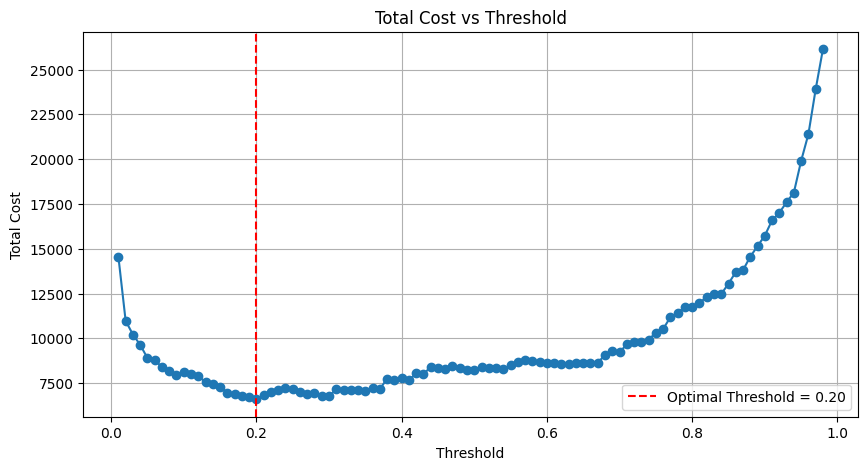

In [33]:
# Use your best model to get predicted probabilities
y_probs = model_weighted.predict_proba(X_test_selected)[:, 1]

# Find best threshold
best_row, cost_report_df = find_optimal_threshold(y_test, y_probs,costs_by_card,X_test.Card_Category)
best_thresh = best_row['Threshold']
print(f"Best Threshold: {round(best_thresh, 3)}")
print(best_row)
plt.figure(figsize=(10, 5))
plt.plot(cost_report_df['Threshold'], cost_report_df['Total_Cost'], marker='o')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Optimal Threshold = {best_thresh:.2f}')
plt.title("Total Cost vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.savefig('../images/threshold_cost_curve.png', bbox_inches='tight')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
# Use selected_features as feature names for SHAP summary plot
explainer = shap.TreeExplainer(model_weighted)
shap_values = explainer.shap_values(X_test_selected)

shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features, plot_type="bar", show=False)
plt.savefig('../images/shap_summary_bar.png', bbox_inches='tight')
plt.close()

In [35]:
not_selected_features = [col for col in df.columns if col not in selected_features]
print(not_selected_features)


['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Income_Category', 'Card_Category', 'Months_Inactive_12_mon', 'Credit_Limit', 'Avg_Utilization_Ratio', 'Trans_Amt_per_Months_Inactive', 'Rev_Bal_per_Trans_Ct', 'Rev_Bal_per_Contacts', 'Rev_Bal_per_Relationship', 'Rev_Bal_per_Dependent', 'Rev_Bal_per_Months_Inactive', 'Open_To_Buy_per_Trans_Ct', 'Open_To_Buy_per_Contacts', 'Open_To_Buy_per_Inactive', 'Open_To_Buy_per_Relationship', 'Open_To_Buy_per_Dependent', 'Open_To_Buy_per_Months_Inactive', 'Credit_Limit_per_Relationship', 'Credit_Limit_per_Months_Inactive', 'Amt_Chng_per_Months_Inactive', 'Utilization_per_Trans_Ct', 'Utilization_per_Trans_Amt', 'Utilization_per_Rev_Bal', 'Utilization_per_Open_To_Buy', 'Utilization_per_Credit_Limit', 'Utilization_per_Contacts', 'Utilization_per_Inactive', 'Utilization_per_Relationship', 'Utilization_per_Dependent', 'Trans_Ct_per_Open_To_Buy', 'Trans_Ct_per_Credit_Limit', 'Sum_Trans_Amt_Open_To_Buy', 'Sum_Rev_Bal_Open_To_Buy', 'Sum_Rev_B

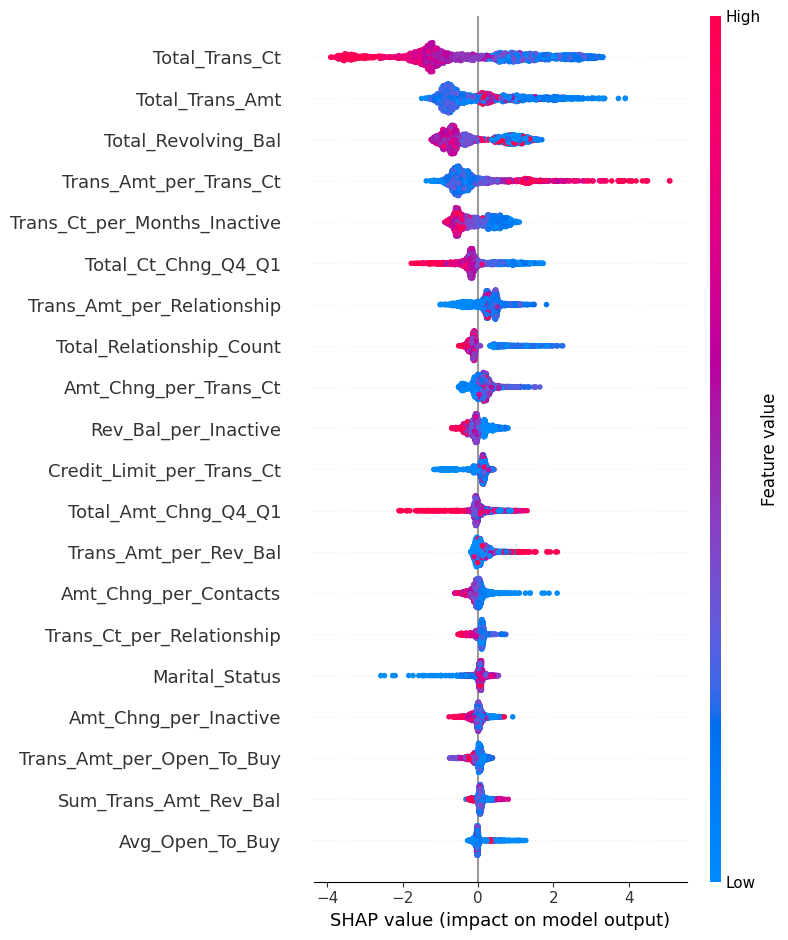

In [36]:
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features, show=False)
plt.savefig('../images/shap_summary.png', bbox_inches='tight')


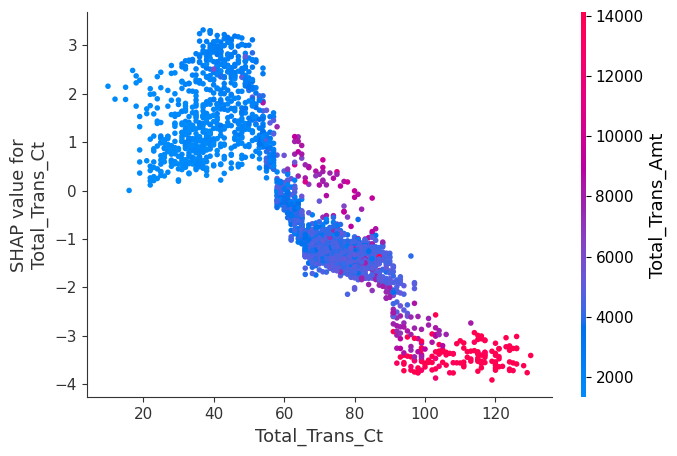

In [37]:
shap.dependence_plot("Total_Trans_Ct", shap_values, X_test_selected,feature_names=selected_features)

In [38]:
# Save model
joblib.dump(model_weighted, '../artifacts/churn_model.pkl')
joblib.dump(tree_preprocessor, '../artifacts/preprocessor.pkl')
with open('../artifacts/feature_order.json', 'w') as f:
    json.dump(selected_features, f)
with open('../artifacts/threshold.json', 'w') as f:
    json.dump({'optimal_threshold': best_thresh}, f)
with open('../artifacts/eliminated_features_by_rfe_needed_for_preprocessor.json', 'w') as f:
    json.dump(not_selected_features, f)
with open('../artifacts/all_features.json','w') as f:
    json.dump(X.columns.to_list(),f)



## Modelling Summary

This section outlines the modeling approach, optimization strategy, and feature importance analysis using SHAP values.

### Modeling Strategy

To predict the likelihood of credit card customer churn, several machine learning models were evaluated, and LightGBM was selected for its strong performance and native handling of imbalanced datasets. The modeling process included:

* **Baseline Training:**
  Initial model training with default hyperparameters and stratified train-test split to preserve target distribution.

* **Class Imbalance Handling:**
  The dataset was imbalanced with a churn ratio of approximately 1:4. To address this, class weights were used in the model to penalize misclassification of the minority (churn) class. SMOTE was also evaluated in earlier experiments but class-weighting with LightGBM provided better consistency and stability.

* **Recursive Feature Elimination (RFE):**
  Feature selection was conducted using RFE to remove redundant or uninformative features. Instead of using standard scoring metrics, RFE was guided using a **cost matrix** that reflects business impact.

### Cost-Based Optimization

Business objectives require minimizing **financial loss** rather than merely optimizing for AUC or F1 score. Therefore, a custom cost function was integrated into the model evaluation, considering:

* **False Negatives (FN):** Customers who churn but are predicted as loyal. This results in revenue loss (Customer Lifetime Value lost).
* **False Positives (FP):** Loyal customers incorrectly identified as churners. This results in unnecessary retention effort (marketing spend).

#### Guesstimate-Based Cost Matrix

Costs were calculated using the following assumptions:

* **Customer Lifetime Value (CLV):**
  CLV = (Average Monthly Spend) × (Revenue Margin) × (Avg. Customer Tenure in Months)
  Revenue margin is assumed to be 5%.

* **Marketing Spend:**
  The retention campaign cost increases with card tier due to premium services required by higher-tier customers.

| Card Category | FN Cost (CLV) | FP Cost (Marketing Spend) |
| ------------- | ------------- | ------------------------- |
| Blue          | ₹212.68       | ₹50                       |
| Silver        | ₹338.02       | ₹100                      |
| Gold          | ₹366.75       | ₹200                      |
| Platinum      | ₹446.88       | ₹300                      |

These costs were used to guide both **feature selection** and **threshold tuning**.

### Feature Engineering Impact

A large number of engineered features—particularly ratios and sums—were ranked highly in terms of SHAP importance. This validates the feature engineering process as a critical step in improving model performance.

Notable engineered features in the top 20 include:

* `Trans_Amt_per_Trans_Ct`
* `Trans_Ct_per_Months_Inactive`
* `Trans_Amt_per_Relationship`
* `Credit_Limit_per_Trans_Ct`
* `Amt_Chng_per_Contacts`

### Model Performance and Cost Reduction

* Final model used LightGBM with optimized hyperparameters and cost-aware threshold.
* Evaluated using standard metrics: ROC-AUC, F1 Score, Confusion Matrix.
* Final cost after optimization: **₹7,442**
* Initial estimated cost without optimization: **₹30,000**

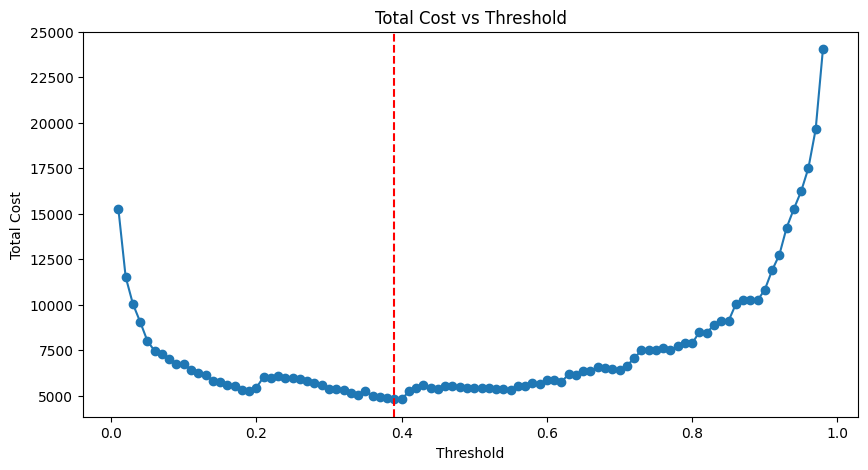

This indicates a **75% reduction in business loss** through strategic modeling and cost-based decision thresholds.

---

## SHAP Analysis

To understand the model’s decision-making process and interpret feature contributions, SHAP (SHapley Additive exPlanations) values were computed.

### SHAP Feature Importance Plot

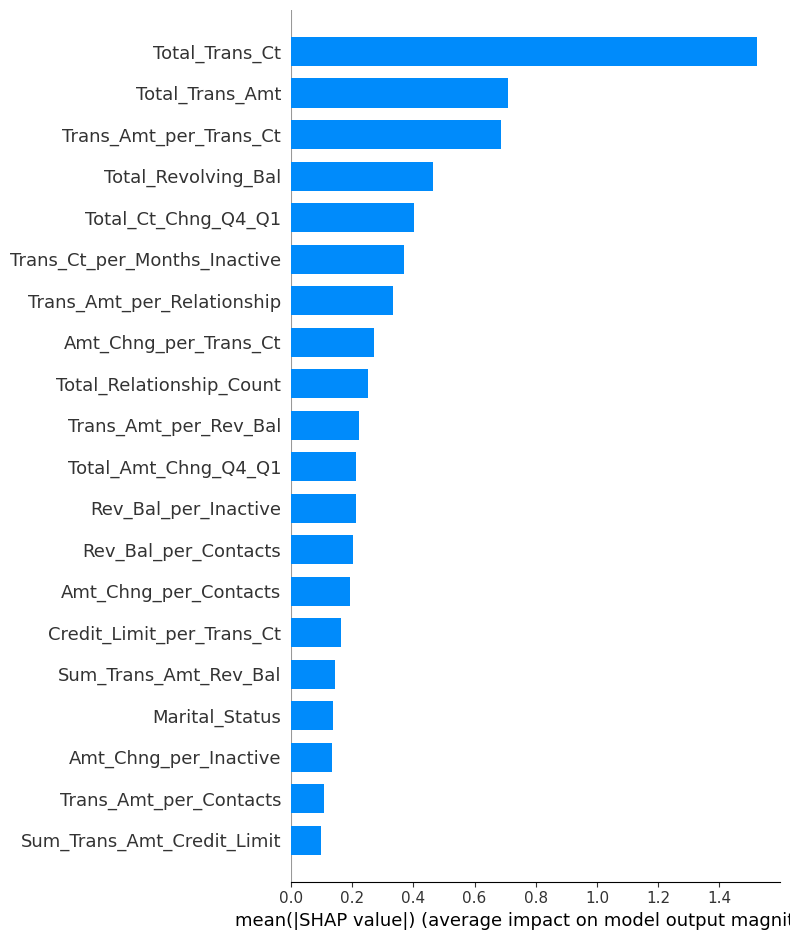

This bar plot shows the average absolute SHAP values, indicating how much each feature contributes to the model predictions across all customers.

* `Total_Trans_Ct` and `Total_Trans_Amt` are the most impactful features, consistent with EDA findings.
* Many engineered ratio-based features are highly influential.

### SHAP Beeswarm Plot

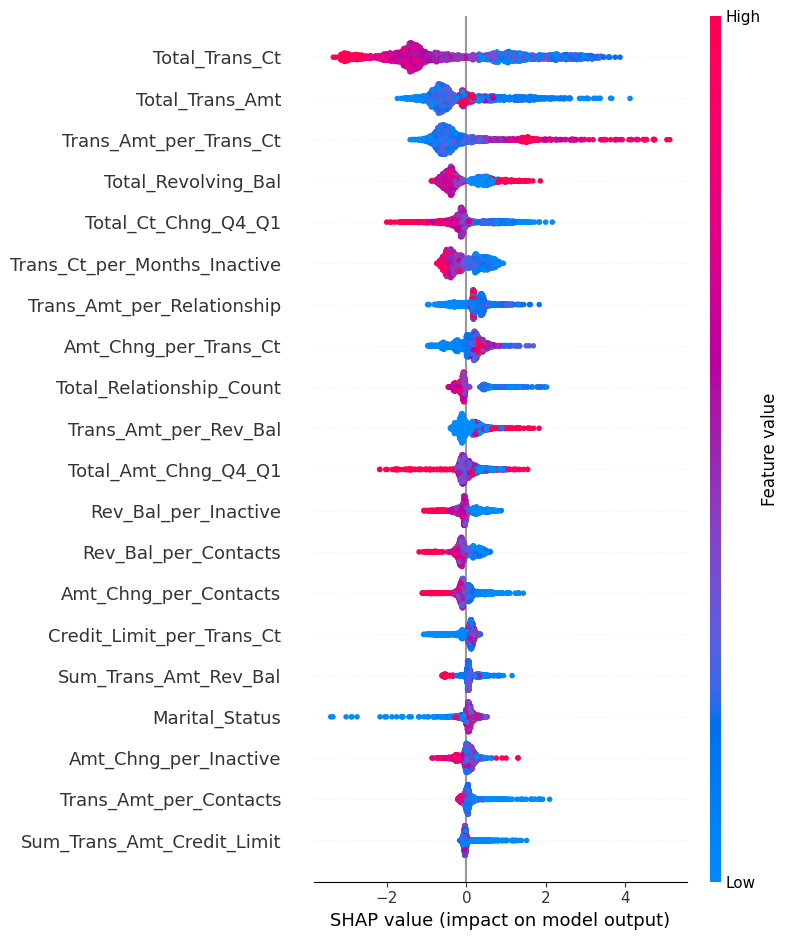
The beeswarm plot shows the distribution of SHAP values for each feature across all samples, colored by feature value.

* Higher transaction count and amount (in red) reduce the likelihood of churn (move prediction left).
* Low values of utilization and engagement features (in blue) increase churn probability.

These plots confirm the **interpretability** and **business relevance** of the selected features and modeling approach.

